In [1]:
import os
import pickle
import time
import numpy as np
import json
import matplotlib.pyplot as plt
from types import SimpleNamespace
from collections import defaultdict
from numba import jit

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists
from power_planner.utils.utils_ksp import (
    KspUtils, get_sp_start_shift, get_sp_dest_shift
)

In [22]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 2  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.ImplicitKSP
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "belgium_dump_" + str(SCALE_PARAM) + ".dat")

with open("../config.json", "r") as infile:
    cfg_dict = json.load(infile)  # Config(SCALE_PARAM)
    cfg = SimpleNamespace(**cfg_dict)
    cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX = compute_pylon_dists(
        cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX, cfg.RASTER, SCALE_PARAM
    )

graph type: <class 'power_planner.graphs.impl_ksp.ImplicitKSP'>
defined pylon distances in raster: 7.5 12.5


In [24]:
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data

In [4]:
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
corridor = np.ones(instance_corr.shape) * 0.5  # start with all

graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=1)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=cfg.ANGLE_WEIGHT
)
# add vertices
graph.add_nodes()

# START PIPELINE
tic = time.time()
print("1) set cost rest")
graph.add_edges()
print("2) added edges", graph.n_edges)
print("number of vertices:", graph.n_nodes)

# weighted sum of all costs
graph.sum_costs()
source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
print("3) summed cost, get source and dest")
# get actual best path
path, path_costs, cost_sum = graph.get_shortest_path(source_v, target_v)
print("4) shortest path")

cost weights [0.16666667 0.27777778 0.20833333 0.13888889 0.20833333]
instance shape (147, 260)
memory taken (dists shape): 1070160
1) set cost rest
time topo sort: 1.119
time edges: 2.349
2) added edges 1070160
number of vertices: 38220
3) summed cost, get source and dest
unweighted edge costs 11.365943265546713
4) shortest path


In [5]:
graph.get_shortest_path_tree(source_v, target_v)

time shortest_path_tree: 1.195


## Implicit KSP with vertices

In [20]:
def k_shortest_paths(self, source, dest, k, overlap=0.5):
    tic = time.time()

    best_paths = [self.best_path]
    tuple_path = [tuple(p) for p in self.best_path]
    sp_set = set(tuple_path)
    # sum both dists_ab and dists_ba, subtract inst because counted twice
    summed_dists = (self.dists + self.dists_ba - self.instance)
    # mins along outgoing edges
    min_node_dists = np.min(summed_dists, axis=0)
    min_shift_dists = np.argmin(summed_dists, axis=0)
    # argsort
    v_shortest = np.argsort(min_node_dists.flatten())
    _, arr_len  = min_node_dists.shape
    c1=0
    c2=0
    t1, t2 = [], []
    expanded = 0
    # e_shortest = np.argsort(min_node_dists.flatten())
    # sorted dists:
    sorted_dists = min_node_dists.flatten()[v_shortest]
    # iterate over edges from least to most costly
    for j in range(len(v_shortest)):
        # f sorted_dists[j] == sorted_dists[j - 1]:
        #    # already checked
        #    print("ho")
        #    c1+=1
        #    continue
        (x2, x3) = v_shortest[j]//arr_len, v_shortest[j]%arr_len
        if j<10:
            assert (x2,x3) in sp_set
        if (x2, x3) in sp_set:
            # print("hi")
            c2+=1
            continue
        x1 = min_shift_dists[x2,x3]
        if self.dists_ba[x1, x2, x3] != 0:
            # = 0 for inc edges of dest_inds (init of dists_ba)
            vertices_path = self._combined_paths(
                source, dest, x1, [x2, x3]
            )
            expanded += 1
        else:
            print("prob")
        # compute similarity with previous paths
        # TODO: similarities
        already = np.array([tuple(u) in sp_set for u in vertices_path])
        # if similarity < threshold, add
        if np.sum(already) < len(already) * overlap:
            best_paths.append(vertices_path)
            tup_path = [tuple(p) for p in vertices_path]
            sp_set.update(tup_path)
            # _, _, cost = self.transform_path(vertices_path)
            # print("found new path with cost", cost)
            # print("sorted dist:", sorted_dists[j])
        if len(best_paths) >= k:
            print(j)
            break

    self.time_logs["ksp"] = round(time.time() - tic, 3)
    return [self.transform_path(path) for path in best_paths]

In [ ]:
tic = time.time()
ksp = k_shortest_paths(graph, start_inds, dest_inds, 5)
print(time.time()-tic)

#### Validate results

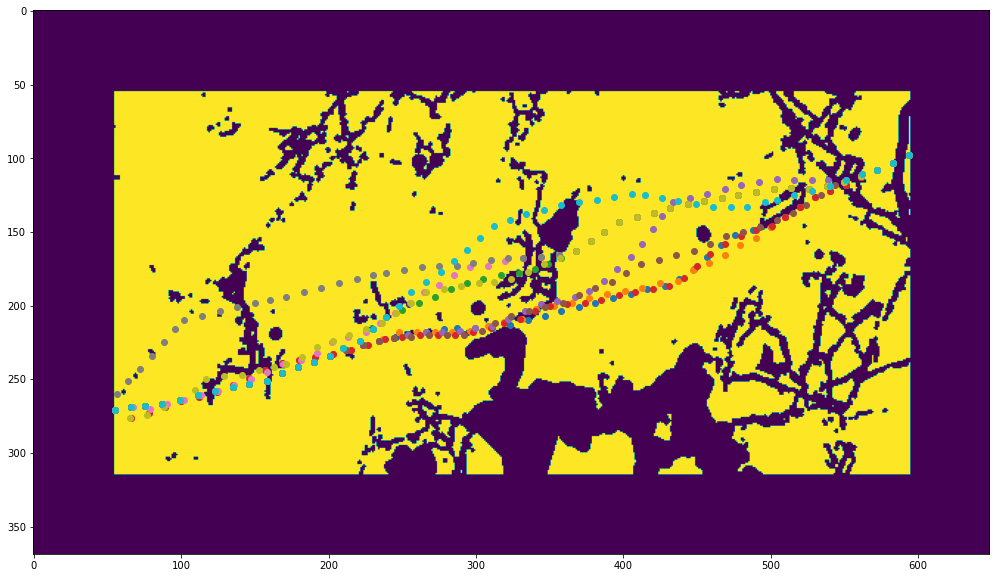

In [36]:
plt.figure(figsize= (20,10))
plt.imshow(instance_corr)
for p in paths:
    p = np.array(p)
    plt.scatter(p[:,1], p[:,0])
    for (i,j) in p:
        if instance_corr[i,j]==0:
            print(i,j)

In [26]:
with open("/Users/ninawiedemann/Desktop/thesis/outputs/testksp_ksp.json", "r") as outfile:
    ksp = json.load(outfile)

In [27]:
paths = [k[0] for k in ksp]

In [28]:
p1 = np.array(paths[0])

## Work on implicit KSP

In [18]:
def k_shortest_paths(self, source, dest, k, overlap=0.5):
    tic = time.time()

    best_paths = [self.best_path]
    tuple_path = [tuple(p) for p in self.best_path]
    sp_set = set(tuple_path)
    # sum both dists_ab and dists_ba, subtract inst because counted twice
    summed_dists = (self.dists + self.dists_ba - self.instance)
    # argsort
    c1=0
    c2=0
    t1, t2 = [], []
    e_shortest = np.argsort(summed_dists.flatten())
    # sorted dists:
    sorted_dists = summed_dists.flatten()[e_shortest]
    # iterate over edges from least to most costly
    for j in range(len(e_shortest)):
        if sorted_dists[j] == sorted_dists[j - 1]:
            # already checked
            c1+=1
            continue
        e = e_shortest[j]
        # compute start and dest v
        x1, x2, x3 = KspUtils._flat_ind_to_inds(e, summed_dists.shape)
        if (x2, x3) in sp_set:
            c2+=1
            continue
        # get shortest path through this node
        tic = time.time()
        vertices_path = self._combined_paths(source, dest, x1, [x2, x3])
        t1.append(time.time()-tic)
        # compute similarity with previous paths
        # TODO: similarities
        tic = time.time()
        already = np.array([tuple(u) in sp_set for u in vertices_path])
        t2.append(time.time()-tic)
        # if similarity < threshold, add
        if np.sum(already) < len(already) * overlap:
            best_paths.append(vertices_path)
            tup_path = [tuple(p) for p in vertices_path]
            sp_set.update(tup_path)
            # _, _, cost = self.transform_path(vertices_path)
            # print("found new path with cost", cost)
            # print("sorted dist:", sorted_dists[j])
            print(j)
        if len(best_paths) >= k:
            print(c1, c2)
            print(np.mean(t1), np.mean(t2))
            print(j)
            break

    self.time_logs["ksp"] = round(time.time() - tic, 3)
    return [self.transform_path(path) for path in best_paths]

In [25]:
0.0056 * 5000

28.0

In [6]:
tic = time.time()
ksp2 = graph.k_shortest_paths(start_inds, dest_inds, 5)
print(time.time()-tic)

/Users/ninawiedemann/Desktop/thesis/power_planner.nosync/power_planner/graphs/impl_ksp.py:169: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


3802
unweighted edge costs 11.365943265546713
unweighted edge costs 11.831819822060124
unweighted edge costs 11.658121730400826
unweighted edge costs 11.82865630526083
unweighted edge costs 11.68588327991453
26.22650909423828


### Baseline

In [28]:
def short_eval(ksp):
    # compute sum of all costs
    return np.sum([k[2] for k in ksp])

In [196]:
ksp = graph.k_shortest_paths(source_v, target_v,10, overlap=0.2, mode="IoU")

In [199]:
ksp_evaluate(ksp)

(79.12363334954276, 3.6775728053512795)

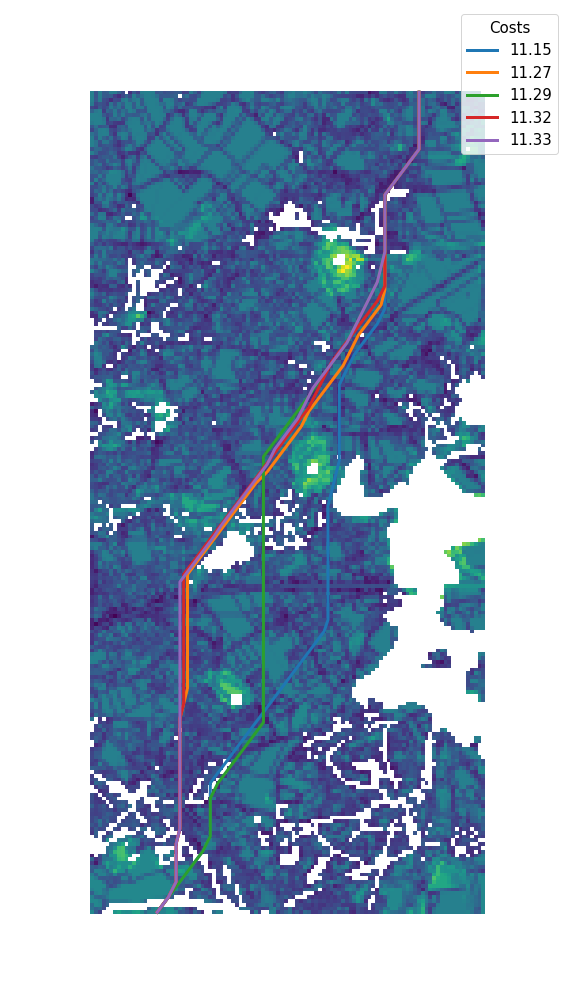

In [11]:
plot_k_sp(ksp2, graph.instance)

## Optimize KSP

In [25]:
best_path_cells, _, best_cost = graph.transform_path(graph.best_path)
best_path = graph.best_path

In [26]:
best_cost

7.661214293650751

In [6]:
# get shortest paths
vertices = np.unique(graph.pos2node)[1:]
v_costs = [graph.instance[(ind // graph.y_len, ind % graph.y_len)] for ind in vertices]
v_dists = [graph.dist_map_ab[v] + graph.dist_map_ba[v] for i, v in enumerate(vertices)]
v_shortest = np.argsort(v_dists)
sorted_dists = np.array(v_dists)[v_shortest]

In [7]:
graph.instance[tuple(dest_inds)]/2, graph.instance[start_inds[0], start_inds[1]]/2

(0.12793022374845409, 0.07995270935960591)

In [33]:
sorted_dists[0], v_shortest[0]

(7.453331360542691, 15332)

In [34]:
7.4533313605426 + 0.12793022374845409 + 0.07995270935960591

7.66121429365066

In [427]:
# proof that they are not the same!!
opt_path = compute_sp(graph, vertices[v_shortest[0]], source_v, target_v)
for b in range(len(best_path)):
    if (opt_path[b]!=best_path[b]):
        print(opt_path[b],best_path[b])

20441 20962
15800 16581


In [ ]:
opt_path = simple_transform()

In [337]:
def compute_sp(self, v, source, dest):
    path_ac = self.get_sp_from_preds(self.pred_map_ab, v, source)
    path_cb = self.get_sp_from_preds(self.pred_map_ba, v, dest)
    # times_getpath.append(time.time() - tic1)
    path_ac.reverse()
    # concatenate - leave 1 away because otherwise twice
    vertices_path = path_ac + path_cb[1:]
    return vertices_path

In [204]:
# params
sim_mode = "IoU"
k = 10
overlap = 1

### get only ksp:

In [133]:
overall_set = set(best_path)
ksp_paths = [best_path]
for j, v_ind in enumerate(v_shortest):
    v = vertices[v_ind]
    if v not in overall_set:
        vertices_path = compute_sp(graph, v, source_v, target_v)
        overall_set.update(vertices_path)
        ksp_paths.append(vertices_path)
        # p, _, cost = graph.transform_path(vertices_path)
        # print(cost)
    if len(ksp_paths)>=k:
        break

In [134]:
ksp_ksp = [graph.transform_path(p) for p in ksp_paths]

In [136]:
cost_sum = short_eval(ksp_ksp)

In [140]:
c_approx = 1.01
max_costs = c_approx * cost_sum

In [414]:
max_costs/10

0.7852744650992018

In [332]:
c_approx = 1.025
max_costs = c_approx*best_cost
print(max_costs)

7.852744650992019


In [21]:
def eucl_dist(p1, p2):
    dists = []
    for p in range(min([len(p1), len(p2)])):
        dists.append(np.linalg.norm(p1[p]-p2[p]))
    return np.mean(dists)
    
def similarity(s1, s2, mode = "IoU"):
    path_inter = len(s1.intersection(s2))
    if mode == "IoU":
        return path_inter / len(s1.union(s2))
    else:
        raise NotImplementedError("mode must be iou")
        
@jit(nopython=True)
def compute_eucl(path1,path2, mode="mean"):
    min_dists_out = np.zeros(len(path1))
    for p1 in range(len(path1)):
        min_dists = np.zeros(len(path2))
        for p2 in range(len(path2)):
            min_dists[p2] = np.linalg.norm(path1[p1]-path2[p2])
        min_dists_out[p1] = np.min(min_dists)
    if mode=="mean":
        return np.mean(min_dists_out)
    elif mode=="max":
        return np.max(min_dists_out)
            
        
def path_distance(p1,p2,mode="jaccard"):
    """
    modes: Jaccard: jaccard distance (1-IoU)
            eucl_mean: from all min eucl distances, take mean
            eucl_max: from all min eucl distances, take max
    """
    if mode=="jaccard":
        s1 = set([tuple(p) for p in p1])
        s2 = set([tuple(p) for p in p2])
        # s1,s2 = (set(list(p1)),set(list(p2)))
        return 1 - len(s1.intersection(s2))/len(s1.union(s2))
    elif mode.startswith("euc"):
        p1 = np.array(p1).astype("float")
        p2 = np.array(p2).astype("float")
        eucl_mode = mode.split("_")[1]
        return max([compute_eucl(p1,p2,mode=eucl_mode), compute_eucl(p2,p1,mode=eucl_mode)])

In [ ]:
path_distance()

In [340]:
start = 0
counter = 20
dist_arr = []
collected_paths = []
for c in range(len(v_shortest)):
    new = sorted_dists[c]
    # check whether exactly the same 
    if np.isclose(new, start):
        counter +=1
        continue
        
    # counter: tells me how many new nodes this path has in contrast to the one before --> skip if not very different  
    if counter<10:
        counter = 1
        start = new
        continue
        
    # elidgible: compute path
    # print(start, counter)
    vertices_path = compute_sp(graph, vertices[v_shortest[c]], source_v, target_v)
    if vertices_path[0]!=source_v or vertices_path[-1]!= target_v:
        print(vertices[v_shortest[c]])
        print(vertices_path)
        raise RuntimeError("source or target not contained")
    collected_paths.append(vertices_path)
    
    # renew the current mindist
    start = new
    counter = 1
    
    # stop to collect paths if costs too high
    if start>max_costs:
        break

In [366]:
len(collected_paths)

46

In [391]:
collected_coords = [simple_transform(p) for p in collected_paths]

In [406]:
dists = np.zeros((len(collected_coords), len(collected_coords)))
for i in range(len(collected_coords)):
    for j in range(i, len(collected_coords)):
        dists[i,j] = path_distance(collected_coords[i], collected_coords[j],mode="jaccard")
        dists[j,i] = dists[i,j]

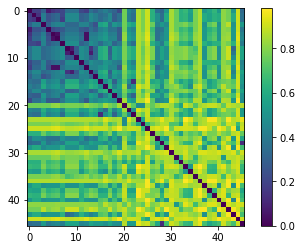

In [407]:
plt.imshow(dists)
plt.colorbar()
plt.show()

In [408]:
nr_paths = len(collected_sets)
d1 = np.argmax(dists)// nr_paths
d2 = np.argmax(dists)% nr_paths

In [409]:
d1,d2

(33, 36)

In [410]:
collected_paths[d1][0], collected_paths[d1][-1], collected_paths[d2][0], collected_paths[d2][-1]

(28102, 10378, 28102, 10378)

In [411]:
nr_paths

46

In [412]:
def plot_path(path):
    coords, _, _ = graph.transform_path(path)
    coords = np.array(coords)
    plt.plot(coords[:,0], coords[:,1])

28102 10378
33
28102 10378
37
28102 10378
41
28102 10378
15
28102 10378
43
28102 10378
29
28102 10378
30
28102 10378
25


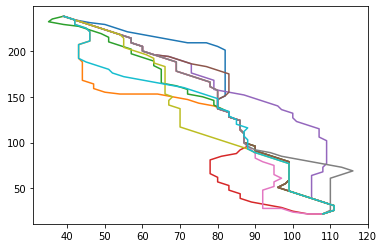

In [401]:
plot_path(collected_paths[d1])
plot_path(collected_paths[d2])
div_ksp = [d1,d2]
for _ in range(8):
    min_dists = []
    for i in range(nr_paths):
        min_dists.append(np.min([dists[i,div_ksp]]))
    d3 = np.argmax(min_dists)
    # print(collected_paths[d3][0], collected_paths[d3][-1])
    # print(d3)
    div_ksp.append(d3)
    plot_path(collected_paths[d3])
plt.show()

### first part (based on prev)

#### Eucledian distance

In [19]:
overlap = 5
k=10
sim_mode="IoU"

In [18]:
best_path = graph.best_path

In [11]:
def simple_transform(path):
    return np.array([(ind // graph.y_len, ind % graph.y_len) for ind in path])

In [17]:
from power_planner.utils.utils_ksp import KspUtils

In [19]:
# set of all considered vertices
overall_set = set(best_path)
# helper set of only the best path
best_set = set(best_path)
# list of currently selected paths
best_paths = []
# same as above, but sets
best_path_sets = [simple_transform(best_path)]
# list of all that are considered
all_considered_paths = []
problematic_paths = []
for j, v_ind in enumerate(v_shortest):
    v = vertices[v_ind]
    if v not in overall_set:
        if int(graph.pred_map_ab[v]) == int(v) or int(graph.pred_map_ba[v]) == int(v):
            continue
        vertices_path = graph.compute_sp(v, source_v, target_v)
        sim_w_best = KspUtils.similarity(best_set, set(vertices_path), mode=sim_mode)
        if sim_w_best<overlap:
            overall_set.update(vertices_path)
            all_considered_paths.append(vertices_path)
        else:
            # do not care further if similarity with best path is already too big
            continue
        # check if diversity wrt to all others is fine
        trans_path = simple_transform(vertices_path)
        sofar = np.array([eucl_dist(trans_path, sp) for sp in best_path_sets])
        # print(sofar)
        # sofar = np.array([graphs.WeightedKSP.similarity(sp, set(vertices_path), sim_mode) for sp in best_path_sets])
        if np.all(sofar > overlap):
            # only store index of current path
            best_paths.append(len(all_considered_paths)-1)
            best_path_sets.append(trans_path)
            problematic_paths.append(0)
            print(j)
        else:
            a = np.where(sofar<=overlap)
            problematic_paths.append(a[-1][0])
    # stop if k paths have been found
    if len(best_paths) >= k:
        break

TypeError: unhashable type: 'numpy.ndarray'

In [24]:
best_paths

[1736, 1979, 2413, 2761, 3062, 3083, 3280, 4187, 4304, 5025]

### consider preliminary result:

In [25]:
len(all_considered_paths), len(v_shortest)

(5026, 19407)

In [26]:
ksp_prelim = [graph.transform_path(p) for p in np.array(all_considered_paths)[best_paths]]

In [29]:
short_eval(ksp_prelim)

78.51553179592396

In [30]:
def ksp_evaluate(ksp, sim_mode= "IoU"):
    costs = [k[2] for k in ksp]
    paths = [k[0] for k in ksp]
    
    path_sets = [set(p) for p in paths]
    
    if sim_mode=="total_nodes":
        return np.sum(costs), len(set.union(*path_sets))
    
    inters = []
    # iterate over all combinations
    for i in range(len(paths)):
        for j in range(i+1,len(paths)):
            if sim_mode == 'eucledian':
                p1 = paths[i]
                p2 = paths[j]
                norms = []
                for k in range(min([len(p1), len(p2)])):
                    norms.append(np.linalg.norm(np.array(p1[k])-np.array(p2[k])))
                inters.append(np.max(norms))
            else:
                print("hi")
                inters.append(similarity(path_sets[i], path_sets[j], mode=sim_mode))
    # print(inters)
    # assert(not any([i==1 for i in inters]))
    return np.sum(costs), np.sum(inters)

In [32]:
ksp_evaluate(ksp_prelim, sim_mode="eucledian")

(78.51553179592396, 923.66100737075)

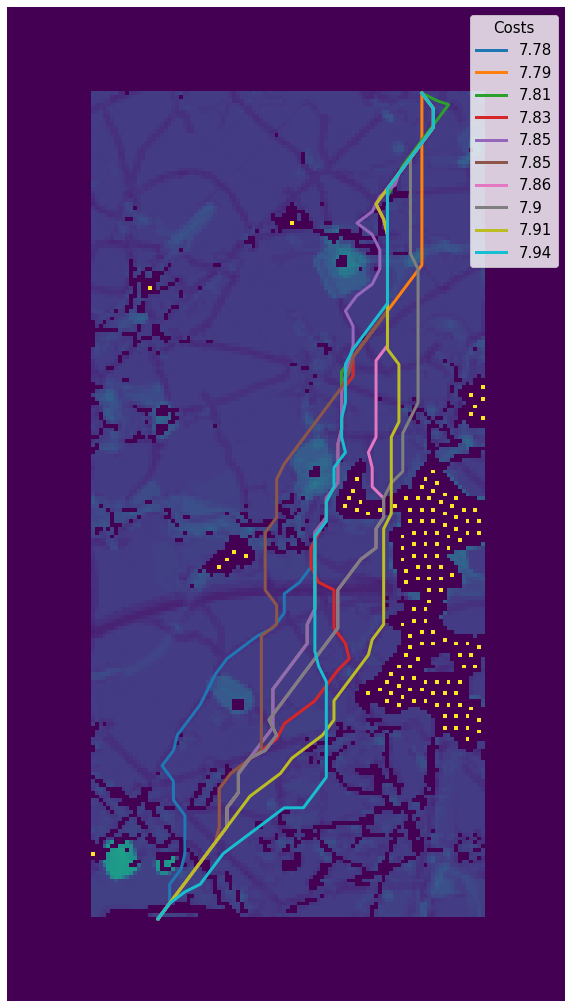

In [31]:
plot_k_sp(ksp_prelim, graph.instance)

### plot all_considered

In [34]:
best_paths

[1736, 1979, 2413, 2761, 3062, 3083, 3280, 4187, 4304, 5025]

In [35]:
arr = np.zeros(instance_corr.shape)
for path in all_considered_paths:
    path_trans = [(ind // graph.y_len, ind % graph.y_len) for ind in path]
    for (i,j) in path_trans:
        arr[i,j] = 1
        
for b in best_paths:
    path_trans = [(ind // graph.y_len, ind % graph.y_len) for ind in all_considered_paths[b]]
    for (i,j) in path_trans:
        arr[i,j]= 2

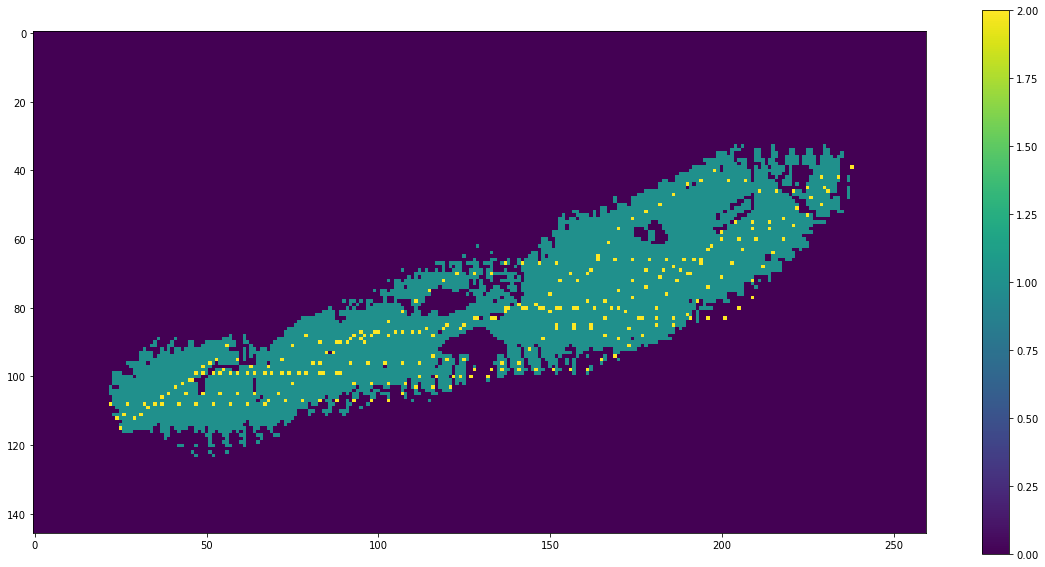

In [36]:
plt.figure(figsize=(20,10))
plt.imshow(arr)
plt.colorbar()
plt.show()

## Refine

Now, we only need to lower the cost by good switching

In [37]:
prob, prob_counts = np.unique(problematic_paths, return_counts=True)

In [38]:
swap_path = best_paths[prob[np.argmax(prob_counts)]]

In [39]:
swap_path

1736

In [40]:
min_path_len = np.min([len(p) for p in all_considered_paths])

In [41]:
cut_paths = np.array([p[:min_path_len] for p in all_considered_paths])

In [42]:
cut_paths.shape

(5026, 49)

## KSP evaluate

In [231]:
def ksp_eval_eucledian(ksp):
    path_pos = [k[0] for k in ksp]
    # path_pos = [[(ind // graph.y_len, ind % graph.y_len) for ind in p] for p in paths]
    
    inters = []
    for i in range(len(path_pos)):
        for j in range(i+1,len(path_pos)):
            p1 = path_pos[i]
            p2 = path_pos[j]
            norms = []
            for k in range(min([len(p1), len(p2)])):
                norms.append(np.linalg.norm(np.array(p1[k])-np.array(p2[k])))
            inters.append(np.max(norms))
            print(i,j,inters[-1])
    for i,p in enumerate(path_pos):
        p = np.array(p)
        plt.plot(p[:,0], p[:,1], label=i)
    plt.legend()
    plt.show()

def compare_ksps(list_of_ksps, plot_labels, k, sim_mode="total_nodes"):
    for i, ksp_comp in enumerate(list_of_ksps):
        costs, sims = [], []
        for ksp in ksp_comp:
            if len(ksp)==k:
                cost, sim = ksp_evaluate(ksp, sim_mode=sim_mode)
                costs.append(cost)
                sims.append(sim)
        plt.plot(sims, costs, label=plot_labels[i])
    plt.title("comparison of ksp algorithms")
    plt.ylabel("sum of costs")
    plt.xlabel("similarity")
    plt.legend()
    plt.show()

### My new formulation: number of unique nodes in set

In [ ]:
def k_shortest_paths_new(self, source, dest, k, overlap=0.5):
    """
    Compute the k shortest path with minumum number of unique vertices
    Arguments:
        source: source vertex
        dest: target vertex
        k: number of paths to output
        overlap: maximum similarity
    """
    tic = time.time()
    THRESH = overlap * k * len(self.best_path)
    # sp_set = set(self.best_path)
    k_paths = [self.best_path]
    # save for each element in which paths it occurs
    occ_dict = defaultdict(list)
    for elem in self.best_path:
        occ_dict[elem].append(0)
    # occ_dict = {elem: [0] for elem in self.best_path}
    
    # get shortest paths
    vertices = np.unique(self.pos2node)[1:]
    v_dists = [self.dist_map_ab[v] + self.dist_map_ba[v] for v in vertices]
    v_shortest = np.argsort(v_dists)
    
    # iterate
    for j, v_ind in enumerate(v_shortest):
        v = vertices[v_ind]
        # v is already in one of the paths
        if v in occ_dict.keys():
            continue
        
        # get path itself
        if int(self.pred_map_ab[v]
                   ) == int(v) or int(self.pred_map_ba[v]) == int(v):
                continue
        # tic1 = time.time()
        try:
            path_ac = self.get_sp_from_preds(
                self.pred_map_ab, v, source
            )
            path_cb = self.get_sp_from_preds(self.pred_map_ba, v, dest)
        except RuntimeWarning:
            print("while loop not terminating")
            continue
        # times_getpath.append(time.time() - tic1)
        path_ac.reverse()
        # concatenate - leave 1 away because otherwise twice
        vertices_path = path_ac + path_cb[1:]

        # if we have less than k paths so far, add immediatly
        if len(k_paths)<k:
            k_paths.append(vertices_path)
            # sp_set.update(vertices_path)
            for v in vertices_path:
                occ_dict[v].append(len(k_paths)-1)
            continue
        # print(occ_dict)
        
        # implement path switch
        overlap_new = np.sum(np.array([u in occ_dict.keys() for u in vertices_path]))
        # skip first one because want to keep SP
        overlaps_prev = [0]
        for prev in k_paths[1:]:
            occs = np.array([len(occ_dict[v]) for v in prev])
            overlaps_prev.append(len(occs[occs>1]))
        
        # for k in range(len(k_paths)):
        #     print(k_paths[k], len(k_paths[k]))
        #     print(overlaps_prev[k])
        # evaluate(k_paths)
        
        # print(np.max(overlaps_prev), overlap_new)
        if np.max(overlaps_prev)> overlap_new:
            # TODO: flip --> if tie than last one
            # print([np.sum(p) for p in k_paths])
            dump_path_ind = np.argmax(overlaps_prev)
            del k_paths[dump_path_ind]
            # print("dumped", dump_path_ind)
            k_paths.insert(dump_path_ind, vertices_path)
            # remove indices from dict
            for key in occ_dict.keys():
                if dump_path_ind in occ_dict[key]:
                	occ_dict[key].remove(dump_path_ind)
            for key in vertices_path:
                occ_dict[key].append(dump_path_ind)
            # print("swapped", dump_path_ind)
        # print(occ_dict)
        check_cond = np.sum([1 for k in occ_dict.keys() if len(occ_dict[k])>0])
        if check_cond>THRESH:
            print("found end")
            print(check_cond, THRESH)
            break
    self.time_logs["ksp"] = round(time.time() - tic, 3)
    p_flat = list()
    for k in k_paths:
        p_flat.extend(k)
    return [self.transform_path(p) for p in k_paths]

In [ ]:
tic = time.time()
ksp = k_shortest_paths_new(graph, source_v, target_v, 10, overlap=0.5)
print(time.time()-tic)

### Compare formulations

In [ ]:
ksps_new = []
ksps_old = []
for i in [0.1, 0.3, 0.5, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    ksp = k_shortest_paths_new(graph, source_v, target_v, 10, overlap=i)
    ksps_new.append(ksp)
    ksp_old = graph.k_shortest_paths(source_v, target_v, 10, overlap=i)
    ksps_old.append(ksp_old)
iou_ksp = []
for i in [0.05, 0.07, 0.1, 0.3, 0.5, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.02]:
    ksp_old = graph.k_shortest_paths(source_v, target_v, 10, overlap=i, mode="eucledian")
    iou_ksp.append(ksp_old)

In [ ]:
compare_ksps([ksps_new, ksps_old, iou_ksp], ["new formulation", "set mode", "IoU"], 10, sim_mode="eucledian")

### Find out about dist_map and pred_map

In [1]:
from graph_tool.all import Graph, shortest_distance
import numpy as np

In [12]:
g = Graph()
g.add_vertex(20)
help = g.new_edge_property("float")
edges = []
for i in range(20):
    inds = np.random.permutation(20)[:3]
    for a in inds:
        edges.append([i+1,a+1,np.random.rand(1)])
g.add_edge_list(edges,eprops=[help])

In [15]:
edges = [e for e in g.vertex(5).out_edges()]

In [16]:
help[edges[2]]

0.7646957038427035

In [4]:
g.is_directed()

True

In [17]:
dists_ab, preds_ab = shortest_distance(
            g,
            1,
            weights=help,
            directed=g.is_directed(),
            pred_map=True
        )
g.set_reversed(is_reversed=True)
dists_ba, preds_ba = shortest_distance(
            g,
            20,
            weights=help,
            directed=g.is_directed(),
            pred_map=True
        )

In [18]:
dists_ab[5], dists_ba[5]

(0.13852138059412944, 1.1023627905454183)

In [36]:
path = "/Users/ninawiedemann/Desktop/Projects/covid19_pocus_ultrasound.nosync/data/my_found_data/"

In [41]:
for f in sorted(os.listdir(path)):
    if f[0]==".":
        continue
    img = plt.imread(path+f)
    print(f, img.shape[0],"x",img.shape[1])

Cov_efsumb1.png 231 x 231
Cov_efsumb1_2.png 219 x 219
Cov_efsumb3.png 499 x 499
Cov_pregnantPublication1.png 213 x 213
Cov_pregnantPublication2.png 377 x 377
Pneu_bikus2.png 654 x 654
Pneu_bikus3.png 717 x 718
Pneu_clarius.jpg 800 x 552
Pneu_clarius2.png 335 x 336
Pneu_sonographiebilder1.jpg 518 x 518
Pneu_sonographiebilder2.jpg 416 x 416
Reg_bikus1.png 429 x 428
Reg_efsumb2.png 474 x 474
Reg_pregnantPublication.png 272 x 372
Reg_publication1.png 321 x 321
